# Oil Spill Detection - Data Preprocessing Pipeline

This notebook implements a robust preprocessing pipeline for oil spill detection based on EDA findings.

## Key Requirements:
- **Same Image Size**: Consistent 256x256 resolution across train/val/test
- **Normalization Consistency**: Same 0-1 scaling for all datasets
- **Shuffling**: Train=True, Val/Test=False
- **Data Balance**: Only augment train set, keep val/test untouched
- **Batch Size**: Consistent across all sets
- **Visual Verification**: Check samples after preprocessing

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

os.makedirs('../results/preprocessing', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

print("Libraries imported successfully")
print("Results directories created")

Libraries imported successfully
Results directories created


## 1. Preprocessing Configuration

In [20]:
CONFIG = {
    'target_size': (256, 256),  # CONSISTENT across all splits
    'batch_size': 32,  # SAME for train/val/test
    'normalize_range': [0, 1],  # CONSISTENT 0-1 scaling
    'binary_threshold': 127,
    'augmentation_prob': 0.5,
    'dataset_path': '../dataset',
    'processed_path': '../data/processed',
    'min_spill_area': 0.1,
    'balance_threshold': 0.3,
    # Shuffling configuration
    'shuffle_train': True,   # Train: shuffle for randomization
    'shuffle_val': False,    # Val: no shuffle for consistent evaluation
    'shuffle_test': False    # Test: no shuffle for consistent evaluation
}

print("Enhanced Preprocessing Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print("\n Key Rules:")
print("  1. Same 256x256 size everywhere")
print("  2. Consistent 0-1 normalization")
print("  3. Train shuffle=True, Val/Test shuffle=False")
print("  4. Only augment train set")
print("  5. Same batch size (32) for all")
print("  6. Visual verification included")

Enhanced Preprocessing Configuration:
  target_size: (256, 256)
  batch_size: 32
  normalize_range: [0, 1]
  binary_threshold: 127
  augmentation_prob: 0.5
  dataset_path: ../dataset
  processed_path: ../data/processed
  min_spill_area: 0.1
  balance_threshold: 0.3
  shuffle_train: True
  shuffle_val: False
  shuffle_test: False

 Key Rules:
  1. Same 256x256 size everywhere
  2. Consistent 0-1 normalization
  3. Train shuffle=True, Val/Test shuffle=False
  4. Only augment train set
  5. Same batch size (32) for all
  6. Visual verification included


## 2. Enhanced Mask Conversion Functions

Testing mask conversion...


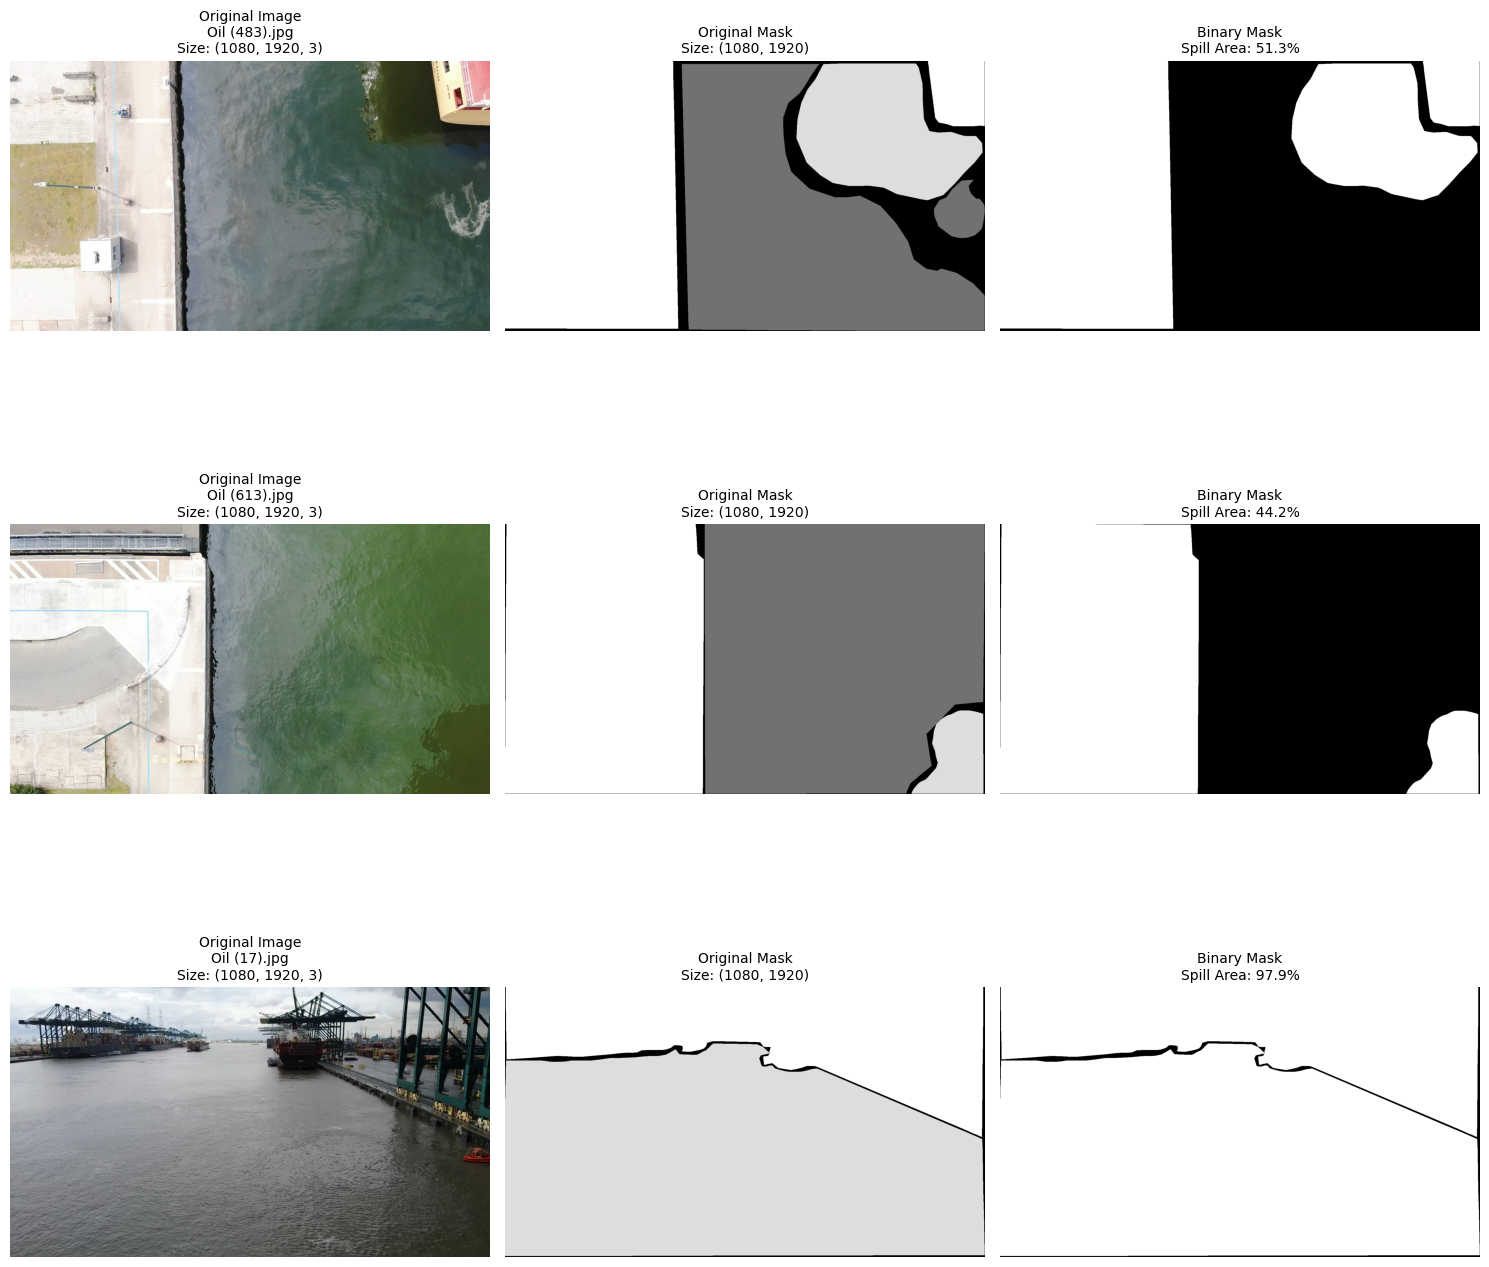


Mask Conversion Statistics:
  Successful conversions: 3
  Failed conversions: 0
  Average spill area: 64.44%
  Spill area range: 44.18% - 97.86%


In [32]:
def convert_rgb_mask_to_binary(mask_path, threshold=None):
    if threshold is None:
        threshold = CONFIG['binary_threshold']
        
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is None:
            mask_pil = Image.open(mask_path).convert('L')
            mask = np.array(mask_pil)
        
        if mask is None:
            return None, f"Could not load mask: {mask_path}"
        
        binary_mask = (mask > threshold).astype(np.uint8)
        
        spill_area = (np.sum(binary_mask) / binary_mask.size) * 100
        
        return binary_mask, spill_area
        
    except Exception as e:
        return None, f"Error converting mask {mask_path}: {e}"

def visualize_mask_conversion(image_path, mask_path, num_samples=3):

    if not (os.path.exists(image_path) and os.path.exists(mask_path)):
        print(f"Paths do not exist: {image_path} or {mask_path}")
        return
    
    image_files = [f for f in os.listdir(image_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(image_files) == 0:
        print("No image files found")
        return
    
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    conversion_stats = {'successful': 0, 'failed': 0, 'spill_areas': []}
    
    for i, img_file in enumerate(sample_files):
        try:
            img = cv2.imread(os.path.join(image_path, img_file))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            mask_file = os.path.splitext(img_file)[0] + '.png'
            original_mask = cv2.imread(os.path.join(mask_path, mask_file), cv2.IMREAD_GRAYSCALE)
            
            binary_mask, spill_info = convert_rgb_mask_to_binary(os.path.join(mask_path, mask_file))
            
            if binary_mask is not None:
                conversion_stats['successful'] += 1
                conversion_stats['spill_areas'].append(spill_info)
            else:
                conversion_stats['failed'] += 1
                print(f"Failed to convert: {spill_info}")
            
            axes[i, 0].imshow(img_rgb)
            axes[i, 0].set_title(f'Original Image\n{img_file}\nSize: {img_rgb.shape}', fontsize=10)
            axes[i, 0].axis('off')
            
            if original_mask is not None:
                axes[i, 1].imshow(original_mask, cmap='gray')
                axes[i, 1].set_title(f'Original Mask\nSize: {original_mask.shape}', fontsize=10)
            axes[i, 1].axis('off')
            
            if binary_mask is not None:
                axes[i, 2].imshow(binary_mask, cmap='gray')
                axes[i, 2].set_title(f'Binary Mask\nSpill Area: {spill_info:.1f}%', fontsize=10)
            axes[i, 2].axis('off')
            
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            conversion_stats['failed'] += 1
    
    plt.tight_layout()
    plt.savefig('../results/preprocessing/mask_conversion_examples.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nMask Conversion Statistics:")
    print(f"  Successful conversions: {conversion_stats['successful']}")
    print(f"  Failed conversions: {conversion_stats['failed']}")
    if conversion_stats['spill_areas']:
        print(f"  Average spill area: {np.mean(conversion_stats['spill_areas']):.2f}%")
        print(f"  Spill area range: {np.min(conversion_stats['spill_areas']):.2f}% - {np.max(conversion_stats['spill_areas']):.2f}%")

train_images_path = os.path.join(CONFIG['dataset_path'], 'train', 'images')
train_masks_path = os.path.join(CONFIG['dataset_path'], 'train', 'masks')

print("Testing mask conversion...")
visualize_mask_conversion(train_images_path, train_masks_path, 3)

## 3. Enhanced Image Preprocessing Functions

In [35]:
def preprocess_image_consistent(image_path, target_size=None, normalize_range=None):
    
    if target_size is None:
        target_size = CONFIG['target_size']
    if normalize_range is None:
        normalize_range = CONFIG['normalize_range']
    
    try:
        image = cv2.imread(image_path)
        if image is None:
            return None, "Could not load image"
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image_resized = cv2.resize(image_rgb, target_size)
        
        image_normalized = image_resized.astype(np.float32) / 255.0
        
        assert image_normalized.shape[:2] == target_size, f"Size mismatch: {image_normalized.shape[:2]} != {target_size}"
        assert image_normalized.min() >= 0 and image_normalized.max() <= 1, f"Normalization error: range [{image_normalized.min():.3f}, {image_normalized.max():.3f}]"
        
        return image_normalized, "success"
        
    except Exception as e:
        return None, f"Error: {e}"

def preprocess_mask_consistent(mask_path, target_size=None):
    if target_size is None:
        target_size = CONFIG['target_size']
    
    try:
        # Convert to binary
        binary_mask, spill_area = convert_rgb_mask_to_binary(mask_path)
        
        if binary_mask is None:
            return None, 0, f"Binary conversion failed: {spill_area}"
        mask_resized = cv2.resize(binary_mask, target_size, interpolation=cv2.INTER_NEAREST)
        
        # Verify consistency
        assert mask_resized.shape == target_size, f"Mask size mismatch: {mask_resized.shape} != {target_size}"
        assert set(np.unique(mask_resized)).issubset({0, 1}), f"Mask values not binary: {np.unique(mask_resized)}"
        
        return mask_resized, spill_area, "success"
        
    except Exception as e:
        return None, 0, f"Error: {e}"

## 4. Enhanced Data Augmentation Pipeline

In [39]:
def verify_preprocessing_samples(split='train', num_samples=6):
    images_path = os.path.join(CONFIG['dataset_path'], split, 'images')
    masks_path  = os.path.join(CONFIG['dataset_path'], split, 'masks')
    
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:num_samples]
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if num_samples == 1: axes = axes.reshape(1, -1)
    
    augmentation_pipeline = get_augmentation_pipeline_enhanced(split)
    
    for i, img_file in enumerate(image_files):
        try:
            img_path  = os.path.join(images_path, img_file)
            mask_file = os.path.splitext(img_file)[0] + '.png'
            mask_path = os.path.join(masks_path, mask_file)
            
            orig_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            orig_mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)
            
            proc_img, _ = preprocess_image_consistent(img_path)
            proc_mask, spill_area, _ = preprocess_mask_consistent(mask_path)
            
            img_uint8 = (proc_img * 255).astype(np.uint8)
            augmented = augmentation_pipeline(image=img_uint8, mask=proc_mask)
            final_img  = augmented['image']
            final_mask = augmented['mask']
            
            axes[i, 0].imshow(orig_img); axes[i, 0].set_title('Original'); axes[i, 0].axis('off')
            axes[i, 1].imshow(orig_mask); axes[i, 1].set_title('Original Mask'); axes[i, 1].axis('off')
            axes[i, 2].imshow(proc_img); axes[i, 2].set_title('Processed'); axes[i, 2].axis('off')
            axes[i, 3].imshow(final_mask, cmap='gray'); axes[i, 3].set_title(f'Final Mask\nSpill: {spill_area:.1f}%'); axes[i, 3].axis('off')
            
        except Exception as e:
            for j in range(4):
                axes[i, j].text(0.5, 0.5, f'Error: {e}', ha='center', va='center')
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f" Visual verification completed for {split} split | Target size: {CONFIG['target_size']} | Normalization: {CONFIG['normalize_range']} | Augmentation: {'Yes' if split=='train' else 'No'}")


## 5. Dataset Balance Analysis and Processing

In [37]:
def process_dataset_split_enhanced(split='train'):
    print(f"PROCESSING {split.upper()} SPLIT WITH CONSISTENCY CHECKS")
    
    images_path = os.path.join(CONFIG['dataset_path'], split, 'images')
    masks_path = os.path.join(CONFIG['dataset_path'], split, 'masks')
    
    if not (os.path.exists(images_path) and os.path.exists(masks_path)):
        print(f" Paths for {split} split do not exist")
        return None
    
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print(f" No images found in {split} split")
        return None
    
    stats = {
        'split': split,
        'total_images': len(image_files),
        'successful_processing': 0,
        'failed_processing': 0,
        'spill_images': 0,
        'non_spill_images': 0,
        'consistency_checks': {'size_consistent': 0, 'normalization_consistent': 0, 'mask_binary': 0},
        'spill_areas': [],
        'processing_errors': [],
        'processed_images': [],
        'processed_masks': [],
        'image_names': []
    }
    
    for img_file in tqdm(image_files, desc=f"Processing {split}"):
        try:
            img_path = os.path.join(images_path, img_file)
            mask_file = os.path.splitext(img_file)[0] + '.png'
            mask_path = os.path.join(masks_path, mask_file)
            
            proc_img, img_status = preprocess_image_consistent(img_path)
            proc_mask, spill_area, mask_status = preprocess_mask_consistent(mask_path)
            
            if proc_img is not None and proc_mask is not None:
                stats['successful_processing'] += 1
                stats['processed_images'].append(proc_img)
                stats['processed_masks'].append(proc_mask)
                stats['image_names'].append(img_file)
                
                if proc_img.shape[:2] == CONFIG['target_size']:
                    stats['consistency_checks']['size_consistent'] += 1
                if 0 <= proc_img.min() <= proc_img.max() <= 1:
                    stats['consistency_checks']['normalization_consistent'] += 1
                if set(np.unique(proc_mask)).issubset({0, 1}):
                    stats['consistency_checks']['mask_binary'] += 1
                
                if spill_area > CONFIG['min_spill_area']:
                    stats['spill_images'] += 1
                    stats['spill_areas'].append(spill_area)
                else:
                    stats['non_spill_images'] += 1
            else:
                stats['failed_processing'] += 1
                stats['processing_errors'].append(f"{img_file}: {img_status}, {mask_status}")
                
        except Exception as e:
            stats['failed_processing'] += 1
            stats['processing_errors'].append(f"{img_file}: {e}")
    
    total_processed = stats['successful_processing']
    if total_processed > 0:
        stats['spill_ratio'] = stats['spill_images'] / total_processed
        stats['consistency_rate'] = {
            'size': stats['consistency_checks']['size_consistent'] / total_processed,
            'normalization': stats['consistency_checks']['normalization_consistent'] / total_processed,
            'mask_binary': stats['consistency_checks']['mask_binary'] / total_processed
        }
        if stats['spill_areas']:
            stats['avg_spill_area'] = np.mean(stats['spill_areas'])
            stats['std_spill_area'] = np.std(stats['spill_areas'])
    
    print(f"\n {split.upper()} RESULTS: {stats['successful_processing']}/{stats['total_images']} processed, {stats['failed_processing']} failed")
    if total_processed > 0:
        print(f"   Spill images: {stats['spill_images']} ({stats['spill_ratio']*100:.1f}%), Avg spill area: {stats.get('avg_spill_area',0):.2f}%")
    
    return stats


## 6. Complete Pipeline Execution

Execute the complete preprocessing pipeline with all consistency checks and visual verification.

 STARTING COMPLETE PREPROCESSING PIPELINE

Processing train split...
PROCESSING TRAIN SPLIT WITH CONSISTENCY CHECKS


Processing train: 100%|██████████| 811/811 [01:32<00:00,  8.79it/s]



 TRAIN RESULTS: 811/811 processed, 0 failed
   Spill images: 757 (93.3%), Avg spill area: 67.63%


Saving train split: 100%|██████████| 811/811 [00:03<00:00, 211.17it/s]



Processing val split...
PROCESSING VAL SPLIT WITH CONSISTENCY CHECKS


Processing val: 100%|██████████| 203/203 [00:14<00:00, 13.94it/s]



 VAL RESULTS: 203/203 processed, 0 failed
   Spill images: 190 (93.6%), Avg spill area: 64.29%


Saving val split: 100%|██████████| 203/203 [00:00<00:00, 228.51it/s]



Processing test split...
PROCESSING TEST SPLIT WITH CONSISTENCY CHECKS


Processing test: 100%|██████████| 254/254 [00:17<00:00, 14.35it/s]



 TEST RESULTS: 254/254 processed, 0 failed
   Spill images: 236 (92.9%), Avg spill area: 67.64%


Saving test split: 100%|██████████| 254/254 [00:01<00:00, 222.90it/s]



 VISUAL VERIFICATION


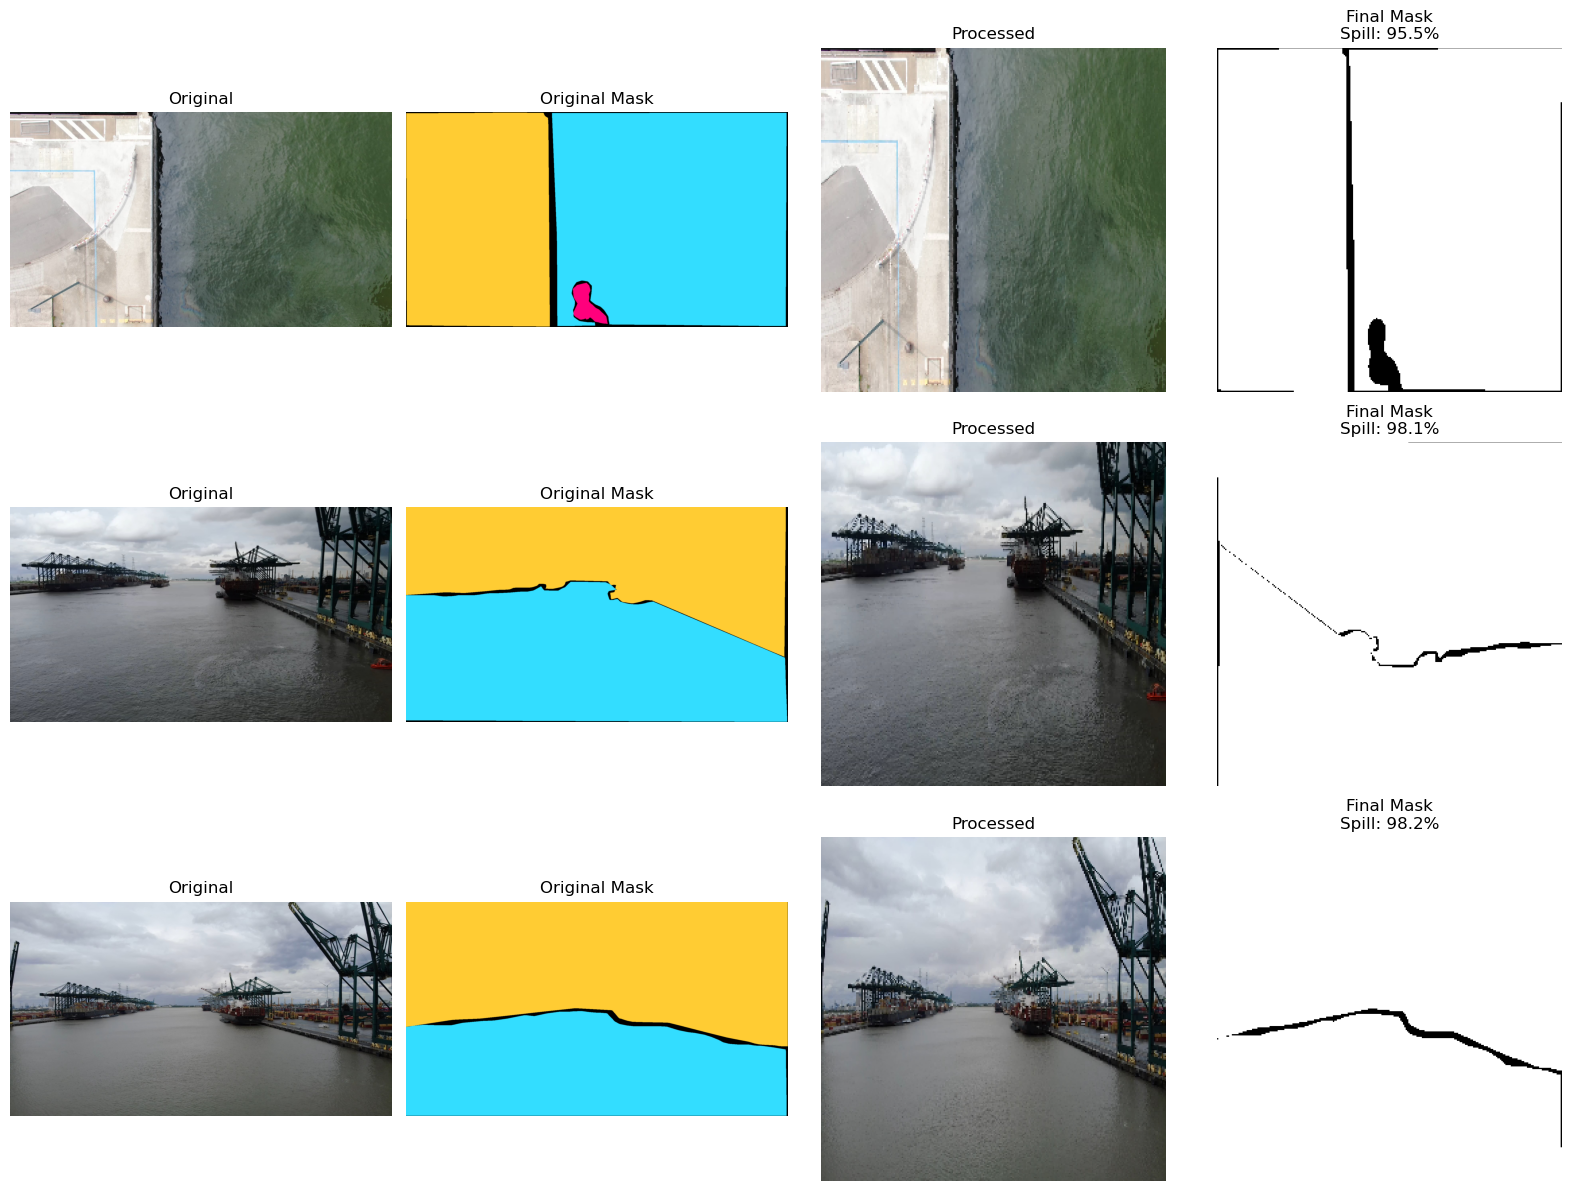

 Visual verification completed for train split | Target size: (256, 256) | Normalization: [0, 1] | Augmentation: Yes


 Visual verification completed for val split | Target size: (256, 256) | Normalization: [0, 1] | Augmentation: No


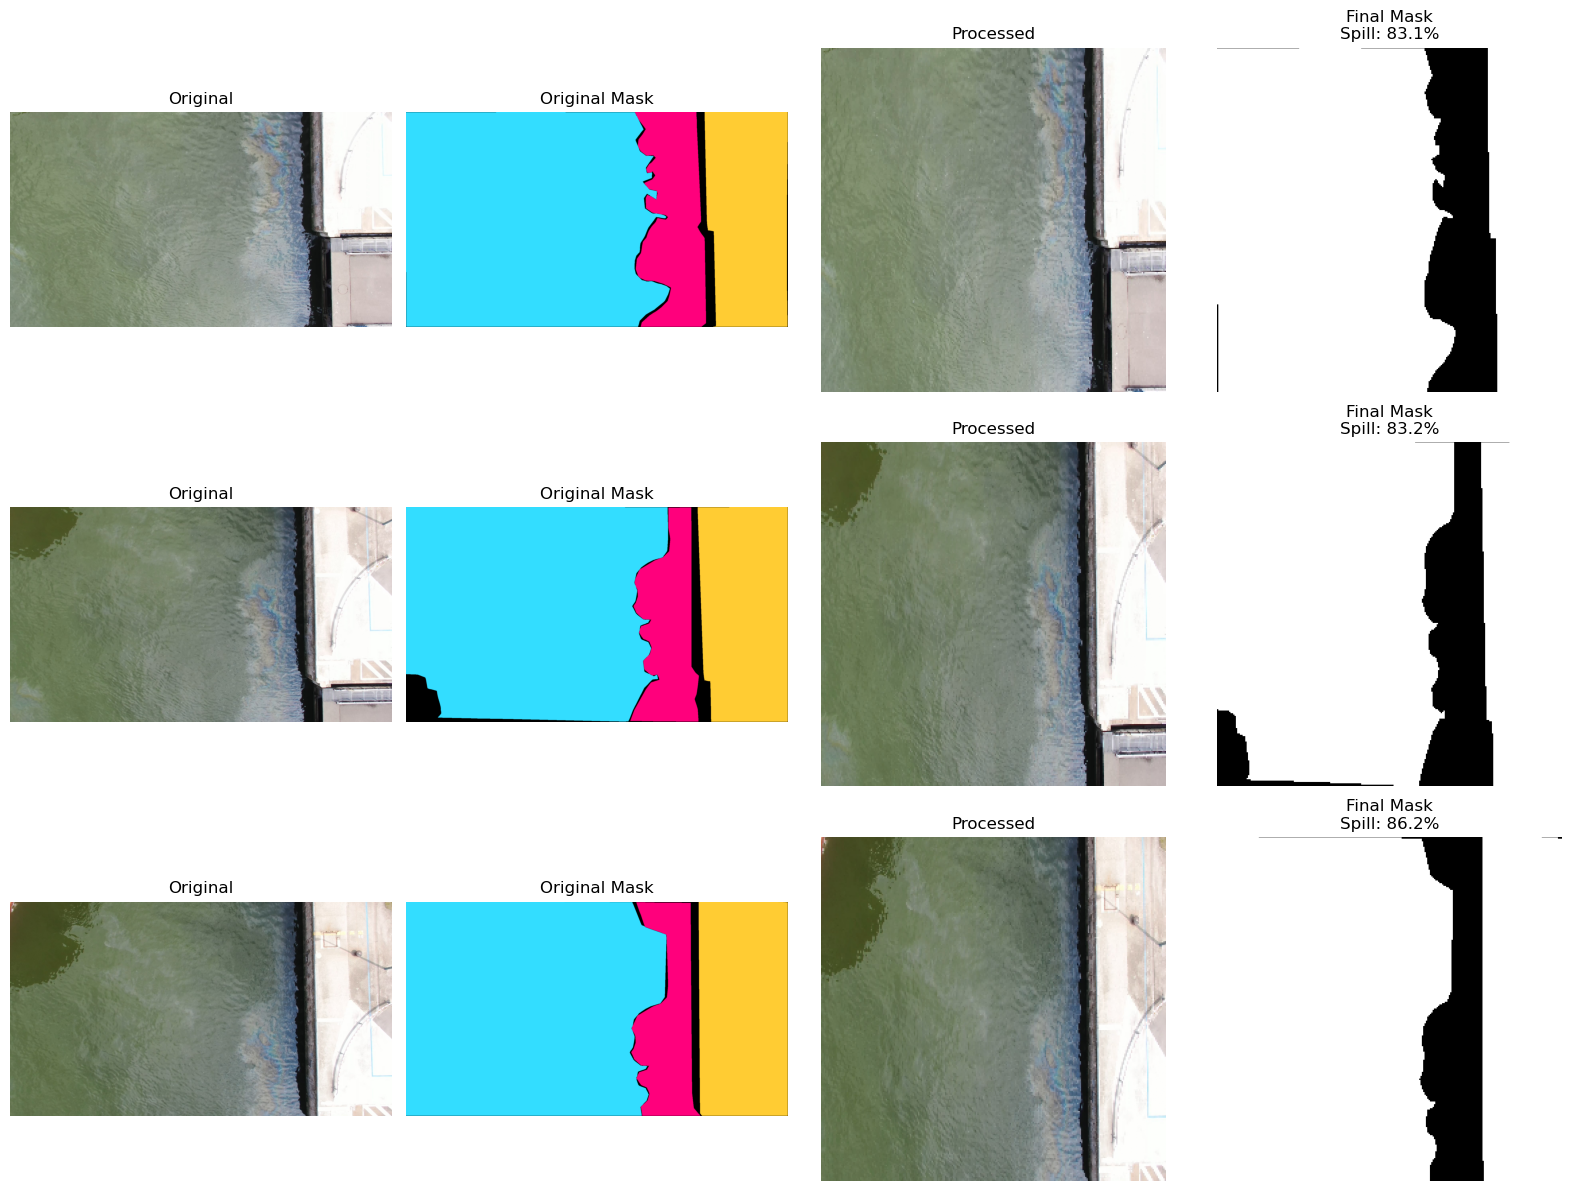

 Visual verification completed for test split | Target size: (256, 256) | Normalization: [0, 1] | Augmentation: No

 FINAL PREPROCESSING SUMMARY

TRAIN Split:
   Processed: 811/811
   Size consistency: 100.0%
   Normalization consistency: 100.0%
   Mask binary consistency: 100.0%
   Spill ratio: 93.3%
   Shuffle setting: True

VAL Split:
   Processed: 203/203
   Size consistency: 100.0%
   Normalization consistency: 100.0%
   Mask binary consistency: 100.0%
   Spill ratio: 93.6%
   Shuffle setting: False

TEST Split:
   Processed: 254/254
   Size consistency: 100.0%
   Normalization consistency: 100.0%
   Mask binary consistency: 100.0%
   Spill ratio: 92.9%
   Shuffle setting: False

 PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!


In [41]:
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(CONFIG['processed_path'], split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(CONFIG['processed_path'], split, 'masks'), exist_ok=True)

print(" STARTING COMPLETE PREPROCESSING PIPELINE")

all_stats = {}
for split in ['train', 'val', 'test']:
    print(f"\nProcessing {split} split...")
    
    stats = process_dataset_split_enhanced(split)
    all_stats[split] = stats

    if stats is not None and stats['successful_processing'] > 0:
     
        for img, mask, img_name in tqdm(zip(stats['processed_images'], stats['processed_masks'], stats['image_names']), total=len(stats['image_names']), desc=f"Saving {split} split"):
            img_path = os.path.join(CONFIG['processed_path'], split, 'images', img_name)
            mask_path = os.path.join(CONFIG['processed_path'], split, 'masks', img_name)
            cv2.imwrite(img_path, (img * 255).astype(np.uint8))
            cv2.imwrite(mask_path, (mask * 255).astype(np.uint8))

print("\n VISUAL VERIFICATION")
for split in ['train', 'val', 'test']:
    if all_stats[split] is not None:
        verify_preprocessing_samples(split, num_samples=3)

print("\n FINAL PREPROCESSING SUMMARY")
for split, stats in all_stats.items():
    if stats is not None and stats['successful_processing'] > 0:
        print(f"\n{split.upper()} Split:")
        print(f"   Processed: {stats['successful_processing']}/{stats['total_images']}")
        print(f"   Size consistency: {stats['consistency_rate']['size']*100:.1f}%")
        print(f"   Normalization consistency: {stats['consistency_rate']['normalization']*100:.1f}%")
        print(f"   Mask binary consistency: {stats['consistency_rate']['mask_binary']*100:.1f}%")
        print(f"   Spill ratio: {stats['spill_ratio']*100:.1f}%")
        print(f"   Shuffle setting: {CONFIG.get(f'shuffle_{split}', False)}")

print("\n PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!")

